In [7]:
# imports
import matplotlib.pyplot as plt
from brian2 import *
from brian2hears import *
import nest
import nest.voltage_trace
nest.set_verbosity("M_ERROR")

In [8]:
# params
NUM_CF = 100 # 3500 (3.5k cochlea ciliar -> 10 ANF for each -> 35000 ANF)

In [9]:
# Inner hair cell model
cfmin, cfmax, cfN = 20*Hz, 20*kHz, NUM_CF
cf = erbspace(cfmin, cfmax, cfN)
sound = tone(1*kHz, 1*second)
# sound = Sound.whitenoise(100*ms)
gfb = Gammatone(sound, cf)
# cochlea modeled as halfwave rectified -> 1/3 power law
ihc = FunctionFilterbank(gfb, lambda x: 3*clip(x, 0, Inf)**(1.0/3.0))

In [10]:
# To create spiking neuron models based on filter chains, you use the
# FilterbankGroup class. This acts exactly like a standard Brian
# NeuronGroup except that you give a source filterbank and choose a
# state variable in the target equations for the output of the
# filterbank

# Leaky integrate-and-fire model with noise and refractoriness
eqs = '''
dv/dt = (I-v)/(1*ms)+0.2*xi*(2/(1*ms))**.5 : 1 (unless refractory)
I : 1
'''
G = FilterbankGroup(ihc, 'I', eqs, reset='v=0',
                    threshold='v>1', refractory=5*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.15s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


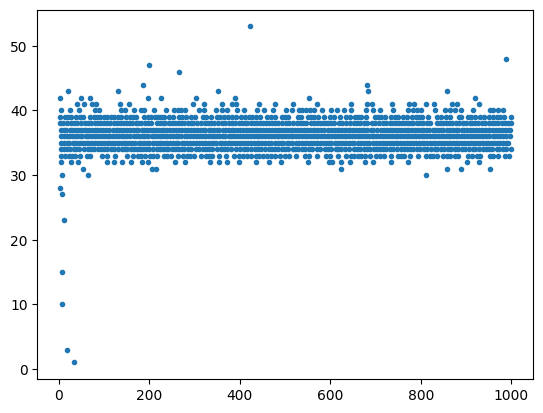

In [11]:
# Run, and raster plot of the spikes
M = SpikeMonitor(G)
run(sound.duration)
plot(M.t/ms, M.i, '.')
show()

In [12]:
spike_trains = [e/ms for i, e in M.spike_trains().items()]

anfs = nest.Create("spike_generator", cfN)
## each cell should create 10 spike generators
for i, e in enumerate(spike_trains):
    nest.SetStatus(anfs[i], params={"spike_times": e,
                                 "allow_offgrid_times": True})
print("NEST spike generator: ", nest.GetStatus(anfs[10])[0]['spike_times'])
print("BRIAN2 original spikes: ", spike_trains[10])

NEST spike generator:  [6.8]
BRIAN2 original spikes:  [6.71201814]
